# Análise da Bay Area Bike Share

## Introdução

> **Dica**: Seções citadas como esta fornecerão instruções úteis sobre como navegar e usar um notebook do iPython.

[Bay Area Bike Share](http://www.bayareabikeshare.com/) é uma empresa que oferece aluguel de bicicletas on-demand para clientes em San Francisco, Redwood City, Palo Alto, Mountain View e San Jose. Os usuários podem desbloquear bicicletas de uma variedade de estações em cada cidade, e devolvê-las em qualquer estação dentro da mesma cidade. Os usuários pagam o serviço por meio de assinatura anual ou pela compra de passes de 3 dias ou 24 horas. Os usuários podem fazer um número ilimitado de viagens. Viagens com menos de trinta minutos de duração não têm custo adicional; Viagens mais longas incorrem em taxas de horas extras.

Neste projeto, você vai se colocar no lugar de um analista de dados realizando uma análise exploratória sobre os dados. Você vai dar uma olhada em duas das principais partes do processo de análise de dados: limpeza de dados e análise exploratória. Mas antes que você comece a olhar os dados, pense algumas perguntas que você pode querer fazer sobre os dados. Considere, por exemplo, se você estivesse trabalhando para Bay Area Bike Share: que tipo de informação você gostaria de saber a fim de tomar decisões de negócios mais inteligentes? Ou você pode pensar se você fosse um usuário do serviço de compartilhamento de bicicletas. Que fatores podem influenciar a maneira como você gostaria de usar o serviço?

# Pergunta 1
Escreva pelo menos duas perguntas que você acha que poderiam ser respondidas usando os dados.

**Resposta**: 

## Usando visualizações para comunicar resultados em dados

Como um analista de dados, a capacidade de comunicar eficazmente resultados é uma parte fundamental do trabalho. Afinal, sua melhor análise é tão boa quanto sua capacidade de comunicá-la.

Em 2014, Bay Area Bike Share realizou um [Open Data Challenge](http://www.bayareabikeshare.com/datachallenge-2014) para incentivar os analistas de dados a criar visualizações com base em seu conjunto de dados aberto. Você criará suas próprias visualizações neste projeto, mas primeiro, dê uma olhada no [vencedor de inscrições para Melhor Análise](http://thfield.github.io/babs/index.html) de Tyler Field. Leia todo o relatório para responder à seguinte pergunta:

# Pergunta 2
Que visualizações você acha que fornecem as idéias mais interessantes? 

Selecione duas visualizações de Tyler que forneçam idéias interessantes e que respondam alguma das perguntas da análise de Tyler.

** Resposta **: 

# Pergunta 2.1

Quais são as perguntas que foram respondidas com suas visualizações? Porque você as escolheu?

** Resposta **:

## Data Wrangling (Limpeza de Dados)

In [24]:
# Importa todas as bibliotecas necessárias
%matplotlib inline
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display


In [33]:
def read_trips_from_file(file_out, file_in, start_date='10/1/2013'):
    with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
        in_reader = csv.reader(f_in)
        out_writer = csv.writer(f_out)

        while True:
            datarow = next(in_reader)
            if datarow[2][:9] == start_date:
                break
            out_writer.writerow(datarow)

october_trip_file = 'data/201310_trip_data.csv'
read_trips_from_file(october_trip_file, 'data/201402_trip_data.csv')

### Condensando os Dados de Viagem

O primeiro passo é analisar a estrutura do conjunto de dados para ver se há alguma limpeza de dados que devemos realizar. A célula abaixo irá ler o arquivo de dados amostrado que você criou na célula anterior. Você deve imprimir as primeiras linhas da tabela.

In [77]:
def read_trips_frame(pathname):
    df = pd.read_csv(pathname)

    # Clean up all datetime columns
    df['End Date'] = df['End Date'].apply(lambda date: datetime.strptime(date, '%m/%d/%Y %H:%M'))
    df['Start Date'] = df['Start Date'].apply(lambda date: datetime.strptime(date, '%m/%d/%Y %H:%M'))

    return df

def display_table(file_in, n=10):
    sample_data = read_trips_frame(file_in)
    display(sample_data.head(n))

display_table(october_trip_file, 7)

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103
5,4927,103,2013-08-29 18:54:00,Golden Gate at Polk,59,2013-08-29 18:56:00,Golden Gate at Polk,59,527,Subscriber,94109
6,4500,109,2013-08-29 13:25:00,Santa Clara at Almaden,4,2013-08-29 13:27:00,Adobe on Almaden,5,679,Subscriber,95112


Nesta exploração, vamos nos concentrar nos fatores nos dados da viagem que afetam o número de viagens realizadas. Vamos focar em algumas colunas selecionadas: a duração da viagem (trip duration), hora de início (start time), terminal inicial (start terminal), terminal final (end terminal) e tipo de assinatura. O tempo de início será dividido em componentes de ano, mês e hora. Também adicionaremos umacoluna para o dia da semana e resumiremos o terminal inicial e final para ser a _cidade_ de início e fim.

In [58]:
COLUMNS = [
    'start_terminal',
    'end_terminal',
    'departure_year',
    'start_month',
    'start_time',
    'end_year',
    'end_month',
    'end_time',
    'week_day',
    'trip_duration',
    'subscription_type'
]

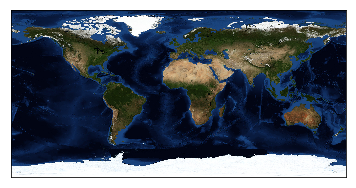

In [95]:
m = Basemap(width=12000,height=9000)
m.bluemarble()
plt.show()

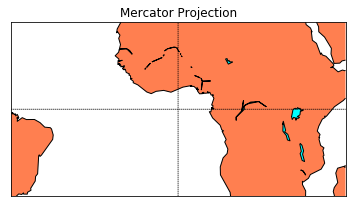

In [83]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(width=12000000,height=9000000, projection='merc', lat_0=-27.5489, lon_0=-46.6388)

# m = Basemap(
#     projection='merc',
#     llcrnrlat=-23.5489,
#     urcrnrlat=23.5489,
#     llcrnrlon=-46.6388,
#     urcrnrlon=46.6388,
#     lat_ts=10,
#     resolution='c'
# )

# bluemarble()
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
# m.drawmapboundary(fill_color='aqua')
plt.title("Mercator Projection")
plt.show()

Vamos primeiro abordar a última parte do processo de limpeza. Execute a célula de código abaixo para ver como as informações da estação estão estruturadas e observe como o código criará o mapeamento estação-cidade. Observe que o mapeamento da estação está configurado como uma função, `create_station_mapping()`. Uma vez que é possível que mais estações sejam adicionadas ou removidas ao longo do tempo, esta função nos permitirá combinar as informações da estação em todas as três partes dos nossos dados quando estivermos prontos para explorar tudo.

In [41]:
# Mostra as primeiras linhas do arquivo de dados das estações
station_info = pd.read_csv('data/201402_station_data.csv')
station_info.head()

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


Preencha a função abaixo de forma que a função retorne um mapeamento entre o id da estação (`station_id`) e a cidade em que ela se encontra (`landmark`).

In [5]:
# esta função será usada mais tarde para criar o mapeamento entre station e cidade
def create_station_mapping(station_data):
    """
    Cria um mapeamento (tambémm conhecido como de-para) entre a estação 
    e a cidade
    """
    # TODO: Inicie esta variável de maneira correta.
    station_map = __
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # configura o objeto csv reader - note que está sendo usado o DictReader,
            # que usa a primeira linha do arquivo como cabeçalho e cria as chaves
            # do dicionário com estes valores.
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                # TODO: faça o mapeamento aqui
    return station_map

IndentationError: expected an indented block (<ipython-input-5-1230aa995d75>, line 18)

Você pode agora usar o mapeamento para condensar as viagens para as colunas selecionadas acima. Isto acontecerá na função abaixo `summarise_data()`. Nela o módulo `datetime` é usado para fazer o **p**arse do tempo (timestamp) em formato de strings no arquivo original para um objeto usando a função `strptime`. Este objeto permitirá a conversão para outros **f**ormatos de datas usando a função `strftime`. O objeto possui também outras funções que facilitam a manipulação dos dados. Veja [este tutorial](http://usandopython.com.br/manipulando-data-hora-python-datetime/) para entender um pouco melhor como trabalhar com a biblioteca.

Você precisa concluir duas tarefas para completar a função `summarise_data()`. Inicialmente, você deverá realizar a operação de converter a duração das viagens de segundos para minutos. Esta é muito fácil, pois existem 60 segundos em um minuto!

Na sequência, você deve criar colunas para o ano, mês, hora e dia da semana. Verifique o tutorial acima ou a [documentação para o objeto de datetime no módulo datetime](https://docs.python.org/2/library/datetime.html#datetime-objects). 

** TODO: Encontre os atributos e métodos necessários para poder completar o código abaixo **

*Dica*: Você pode abrir uma nova caixa para testar um pedaço do código ou verificar uma variável que seja global. Caso ela esteja dentro da função, você também pode usar o comando `print()` para imprimi-la e ajudar no Debug.

In [5]:
def summarise_data(trip_in, station_data, trip_out):
    """
    Esta função recebe informações de viagem e estação e produz um novo
    arquivo de dados com um resumo condensado das principais informações de viagem.Os 
    argumentos trip_in e station_data serão listas de arquivos de dados para
    as informações da viagem e da estação enquanto trip_out especifica o local
    para o qual os dados sumarizados serão escritos.
    """
    # gera o dicionário de mapeamento entre estações e cidades
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # configura o objeto de escrita de csv       
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # configura o leitor do csv
                trip_reader = csv.DictReader(f_in)

                # processa cada linha lendo uma a uma
                for row in trip_reader:
                    new_point = {}
                    
                    # converte a duração de segundos para minutos.
                    ### TODO: Pergunta 3a: Adicione uma operação matemática       ###
                    ### para converter a duração de segundos para minutos.  ###
                    new_point['duration'] = ___
                    
                    # reformate strings com datas para múltiplas colunas
                    ### TODO: Pergunta 3b: Preencha os __ abaixo para criar os        ###
                    ### campos experados nas colunas (olhe pelo nome da coluna) ###
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.__
                    new_point['start_year']  = trip_date.__
                    new_point['start_month'] = trip_date.__
                    new_point['start_hour']  = trip_date.__
                    new_point['weekday']     = trip_date.__
                    
                    # TODO: mapeia o terminal de inicio e fim com o a cidade de inicio e fim
                    new_point['start_city'] = __
                    new_point['end_city'] = __
                    
                    # TODO: existem dois nomes diferentes para o mesmo campo. Trate cada um deles.
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = __
                    else:
                        new_point['subscription_type'] = __

                    # escreve a informação processada para o arquivo de saída.
                    trip_writer.writerow(new_point)

# Pergunta 3: 
Execute o bloco de código abaixo para chamar a função `summarise_data()` que você terminou na célula acima. Ela usará os dados contidos nos arquivos listados nas variáveis `trip_in` e `station_data` e escreverá um novo arquivo no local especificado na variável `trip_out`. Se você executou a limpeza de dados corretamente, o bloco de código abaixo imprimirá as primeiras linhas do DataFrame e uma mensagem que verificando se as contagens de dados estão corretas.

In [6]:
# processe os dados usando a função criada acima
station_data = ['201402_station_data.csv']
trip_in = ['201309_trip_data.csv']
trip_out = '201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

NameError: global name 'create_station_mapping' is not defined

In [ ]:
# Carregue os dados novamente mostrando os dados
## TODO: Complete o código para leitura dos dados no arquivo criado na função acima
sample_data = ___
display(sample_data.head())

In [ ]:
# Verifica o DataFrame contando o número de pontos de dados com as características de 
# tempo corretas.
question_3(sample_data)

> **Dica**: se você salvar um notebook do jupyter, a saída dos blocos de código em execução também será salva. No entanto, o estado do seu arquivo será reiniciado uma vez que uma nova sessão será iniciada. Certifique-se de que você execute todos os blocos de código necessários da sessão anterior para restabelecer variáveis e funções antes de continuar de onde você deixou na última vez.

## Análise Exploratória de Dados 

Agora que você tem alguns dados salvos em um arquivo, vejamos algumas tendências iniciais nos dados. Algum código já foi escrito para você no script [babs_visualizations.py](babs_visualizations.py) para ajudar a resumir e visualizar os dados; Isso foi importado como as funções `usage_stats()` e `usage_plot()`. Nesta seção, vamos percorrer algumas das coisas que você pode fazer com as funções, e você usará as funções para você mesmo na última parte do projeto. Primeiro, execute a seguinte célula para carregar os dados. Depois preencha a célula abaixo com os comandos para verificar os dados básicos sobre os dados.

In [ ]:
trip_data = pd.read_csv('201309_trip_summary.csv')

In [ ]:
# TODO: preencha os campos com os dados de acordo com o print
print('Existem {:d} pontos no conjunto de dados'.format(__))
print('A duração média das viagens foi de {:.2f} minutos'.format(__))
print('A mediana das durações das viagens foi de {:.2f} minutos'.format(__))

# TODO: verificando os quartis
duration_qtiles = trip_data['duration'].quantile([.25, .5, .75]).as_matrix()
print('25% das viagens foram mais curtas do que {:.2f} minutos'.format(__))
print('25% das viagens foram mais compridas do que {:.2f} minutos'.format(__))

In [ ]:
# execute este campo para verificar os seu processamento acima.
usage_stats(trip_data)

Você deve ver que há mais de 27.000 viagens no primeiro mês e que a duração média da viagem é maior do que a duração mediana da viagem (o ponto em que 50% das viagens são mais curtas e 50% são mais longas). Na verdade, a média é maior que as durações de 75% das viagens mais curtas. Isso será interessante para ver mais adiante.

Vamos começar a ver como essas viagens são divididas por tipo de inscrição. Uma maneira fácil de construir uma intuição sobre os dados é traçá-los. 

Lembre-se que o Pandas possui maneiras de plotar os gráficos diretamente de um DataFrame. Para cada tipo de dados/análises se pode usar um tipo diferente de gráfico mais apropriado para a análise que se está fazendo.

Na caixa abaixo, faça um gráfico de viagens x tipo de subscrição do tipo barras.

In [ ]:
# TODO: plote um gráfico de barras que mostre quantidade de viagens por subscription_type
# lembrando que quando o comando .plot é usado, se pode escolher o tipo de gráfico usando 
# o parâmetro kind. Ex: plot(kind='bar')

Para que você possa conferir se os seus gráficos estão corretos, usaremos a função `use_plot()`. O segundo argumento da função nos permite contar as viagens em uma variável selecionada, exibindo as informações em um gráfico. A expressão abaixo mostrará como deve ter ficado o seu gráfico acima.

In [ ]:
# como o seu gráfico deve ficar. Descomente a linha abaixo caso queira rodar este comando
# usage_plot(trip_data, 'subscription_type')

>*Nota*: Perceba que provavelmente o seu gráfico não ficou exatamente igual, principalmente pelo título e pelo nome dos eixos. Lembre-se, estes são detalhes mas fazem toda a diferença quando você for apresentar os gráficos que você analisou. Neste Nanodegree não focaremos nestas questões, mas tenha em mente que ter os gráficos acertados é de extrema importância.

Parece que existe 50% mais viagens feitas por assinantes (subscribers) no primeiro mês do que outro tipos de consumidores. Vamos tentar uma outra variável. Como é a distribuição da duração das viagens (trip duration)?

In [ ]:
# TODO: Faça um gráfico baseado nas durações

In [ ]:
# rode este comando abaixo caso esteja em dúvida quanto ao resultado esperado
# usage_plot(trip_data, 'duration')

Parece muito estranho, não é? Dê uma olhada nos valores de duração no eixo x. A maioria dos passeios deve ser de 30 minutos ou menos, uma vez que há taxas de excesso de tempo extra em uma única viagem. A primeira barra abrange durações de até 1000 minutos, ou mais de 16 horas. Com base nas estatísticas que obtivemos do `use_stats()`, deveríamos ter esperado algumas viagens com durações muito longas que levem a média a ser muito superior à mediana: o gráfico mostra isso de forma dramática, mas inútil.

Ao explorar os dados, muitas vezes você precisará trabalhar com os parâmetros da função de visualização para facilitar a compreensão dos dados. É aqui que os filtros vão ajudar você. Comecemos por limitar as  viagens de menos de 60 minutos.

In [ ]:
# TODO: faça um gráfico de barras para os dados com duração inferior a 60 minutos.

In [ ]:
# descomente a linha abaixo para verificar o gráfico esperado.
# usage_plot(trip_data, 'duration', ['duration < 60'])

Isso está bem melhor! Você pode ver que a maioria das viagens têm menos de 30 minutos de duração, mas que você pode fazer mais para melhorar a apresentação. Uma vez que a duração mínima não é 0, a barra da esquerda está ligeiramente acima de 0. Nós queremos saber onde existe um limite perto dos 30 minutos, então ficará mais agradável se tivermos tamanhos de intervalos (bin sizes) e limites dos intervalos que correspondam a alguns minutos. 

Felizmente, o Pandas e o Matplotlib te dão a opção de resolver ester problemas. Uma das maneiras de fazê-lo é definindo qual o intervalo no eixo x (parâmetro range) e quantos intervalos desejamos (bins).

No campo abaixo, faça o ajuste do gráfico para que os limites das barras se encontrem nas extremidades e que as barras tenham tamanho 5 (0, 5, 10, 15, etc). Se precisar, use a [documentação](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.hist.html#matplotlib.axes.Axes.hist).

In [ ]:
# faça o gráfico ajustado que começará no 0 e terá o bin size de 5

In [ ]:
# rode esta linha para verificar como deve ficar o seu gráfico
#usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

Pequenos ajustes como este podem ser pequenos mas fazem toda a diferença na entrega de um trabalho de qualidade e com atenção aos detalhes.


# Pergunta 4

Analise o histograma do exercicio anterior e responda:

Qual o intervalo de duração com maior quantidade de viagens?


**Reposta**: Substitua este texto pela sua resposta!

# Pergunta 4.1

Com base na sua resposta da pergunta anterior, conte quantas viagens existem para cada origem e destino desse intervalo de tempo. Monte uma tabela que demonstre isso. 

Qual origem e destino tem a maior quantidade de viagens?  Aproximadamente quantas viagens foram feitas nesta faixa de tempo?


 **Reposta**: Substitua este texto pela sua resposta!

## Fazendo suas Próprias Análises

Agora que você fez alguma exploração em uma pequena amostra do conjunto de dados, é hora de avançar e reunir todos os dados em um único arquivo e ver quais tendências você pode encontrar. O código abaixo usará a mesma função `summarise_data()` para processar dados. Depois de executar a célula abaixo, você terá processado todos os dados em um único arquivo de dados. Observe que a função não exibirá qualquer saída enquanto ele é executado, e isso pode demorar um pouco para ser concluído, pois você tem muito mais dados do que a amostra com a qual você trabalhou.

In [ ]:
station_data = [
    '201402_station_data.csv',
    '201408_station_data.csv',
    '201508_station_data.csv'
]

trip_in = [
    '201402_trip_data.csv',
    '201408_trip_data.csv',
    '201508_trip_data.csv'
]

trip_out = 'babs_y1_y2_summary.csv'

# Esta função irá ler as informações das estações e das viagens
# e escreverá um arquivo processado com o nome trip_out
summarise_data(trip_in, station_data, trip_out)

Já que a função `summarise_data()` escreveu um arquivo de saída, a célula acima não precisa ser rodada novamente mesmo que este notebook seja fechado e uma nova sessão seja criada. Você pode simplesmente ler os dados novamente e fazer a exploração deste ponto (não esqueça de executar a parte das funções no começo do notebook caso esteja em uma nova sessão)

In [ ]:
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())

#### Agora é a SUA vez de fazer a exploração do dataset (do conjunto de dados) completo.

Aproveite para fazer filtros nos dados e tentar encontrar padrões nos dados.

Explore algumas variáveis diferentes usando o mesmo racional acima e tome nota de algumas tendências que você encontra. Sinta-se livre para criar células adicionais se quiser explorar o conjunto de dados de outras maneiras ou de várias maneiras.

> **Dica**: para adicionar células adicionais a um notebook, você pode usar as opções "Inserir célula acima" (Insert Cell Above) e "Insert Cell Below" na barra de menu acima. Há também um ícone na barra de ferramentas para adicionar novas células, com ícones adicionais para mover as células para cima e para baixo do documento. Por padrão, as novas células são do tipo de código; Você também pode especificar o tipo de célula (por exemplo, Código ou Markdown) das células selecionadas no menu Cell ou no menu dropdown na barra de ferramentas.

Um feito com suas explorações, copie as duas visualizações que você achou mais interessantes nas células abaixo e responda as seguintes perguntas com algumas frases descrevendo o que você encontrou e por que você selecionou os números. Certifique-se de que você ajusta o número de caixas ou os limites da bandeja para que efetivamente transmitam os resultados dos dados. Sinta-se livre para complementar isso com quaisquer números adicionais gerados a partir de `use_stats()` ou coloque visualizações múltiplas para suportar suas observações.

Para ver alguns outros tipos de gráficos que o matplotlib (padrão do Pandas) possui, leia [este artigo](https://www.labri.fr/perso/nrougier/teaching/matplotlib/#other-types-of-plots). 

Para entender um pouco mais como e quais gráficos podem ser úteis, leia [este documento](https://www.tableau.com/sites/default/files/media/Whitepapers/which_chart_v6_ptb.pdf). Ele lhe dará um pouco de idéia de como mostrar os dados de forma mais acertada

# Pergunta 5a
Explore os dados e faça um gráfico que demonstre alguma particularidade dos dados:

In [ ]:
# Gráfico final 1


O que é interessante na visualização acima? Por que você a selecionou?

**Answer**: Escreva a sua resposta aqui

# Pergunta 5b
Faça um gráfico que demonstre alguma particularidade dos dados:

In [ ]:
# Gráfico Final 2

O que é interessante na visualização acima? Por que você a selecionou?

**Answer**: Escreva a sua resposta aqui

## Conclusões

Parabéns pela conclusão do projeto! Esta é apenas uma amostragem do processo de análise de dados: gerando perguntas, limpando e explorando os dados. Normalmente, neste momento no processo de análise de dados, você pode querer tirar conclusões realizando um teste estatístico ou ajustando os dados a um modelo para fazer previsões. Há também muitas análises potenciais que podem ser realizadas se evoluirmos o código fornecido. Em vez de apenas olhar para o número de viagens no eixo de resultados, você pode ver quais recursos afetam coisas como a duração da viagem. Nós também não analisamos como os dados meteorológicos se encaixam no uso de bicicletas.

# Pergunta 6
Pense em um tópico ou campo de interesse onde você gostaria de poder aplicar as técnicas da ciência dos dados. O que você gostaria de aprender com o assunto escolhido?

**Responda**: Substitua este texto pela sua resposta!

> **Dica**: se quisermos compartilhar os resultados de nossa análise com os outros, existe uma outra opção que não é enviar o arquivo jupyter Notebook (.ipynb). Também podemos exportar a saída do Notebook de uma forma que pode ser aberto mesmo para aqueles sem o Python instalado. No menu **File** na parte superior esquerda, vá para o submenu **Download as**. Você pode então escolher um formato diferente que pode ser visto de forma mais geral, como HTML (.html) ou PDF (.pdf). Você pode precisar de pacotes adicionais ou software para executar essas exportações.